<a href="https://colab.research.google.com/github/alzimna/Anmul/blob/main/Chapters/Bab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import scipy
import os
import math
import cv2
import shutil
import requests, zipfile, io
from PIL import Image
from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from IPython.display import clear_output


def accuracy_rate(df) :
  trace = df.to_numpy().trace()
  total = df.to_numpy().sum()
  return(trace/total)

def hog_data_extractor(jpeg_path):
    jpeg_data = cv2.imread(jpeg_path,cv2.IMREAD_GRAYSCALE)
    jpeg_data=cv2.resize(jpeg_data,(80,60))
    hog_data = feature.hog(jpeg_data)/255.0
    return hog_data

#**BAB 9**

##  9.2 CLASSIFICATION INTO TWO GROUPS

### **Example 9.2**

For the psychological data of Table 5.1, $y_1$, $y_2$, and $S_{pl}$ were obtained in Example 5.4.2. The discriminant function coefficients were obtained in Example 5.5 as $a' = (.5104, -.2032, .4660, -.3097)$. For $G_1$ (the male group), we find
$$\bar{\mathbf{z}}_1 = a'\bar{\mathbf{y}}_1 =  .5104(15.97) - .2032(15.91) + .4660(27.19) - .3097(22.75)\\
=10.5427$$

Similarly, for $G_2$ (the female group), $\mathbf{z}_2 = \mathbf{a}'
\bar{\mathbf{y}}_2 = 4.4426$. Thus we assign an observation vector $\mathbf{y}$ to $G_1$ if
$$
z = \mathbf{a}'\mathbf{y} >\frac{1}{2}(z_1+z_2) =  7.4927
$$
and assign $\mathbf{y}$ to $G_2$ if $z < 7.4927$.

There are no new observations available, so we will illustrate the procedure
by classifying two of the observations in $G_1$. For $\mathbf{y}'_{11} = (15, 17, 24, 14)$, the first observation in $G_1$, we have $z_{11} = \mathbf{a}'y_{11} = .5104(15) - .2032(17) + .4660(24) -.3097(14) = 11.0498$, which is greater than $7.4927$, and $y_{11}$ would be correctly classified as belonging to $G_1$. For $y_{14} = (13, 12, 10, 16)$, the fourth observation in $G_1$, we find $z_{14} = 3.9016$, which would misclassify $y_{14}$ into $G_2$.

In [2]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/t5.1.xlsx'
data = pd.read_excel(url)
print(data.head())
y1_bar = round(data.iloc[:,:4].mean(),2).values
y2_bar = round(data.iloc[:,4:].mean(),2).values
S1 = round(pd.DataFrame.cov(data.iloc[:,:4]),3).values
S2 = round(pd.DataFrame.cov(data.iloc[:,4:]),3).values
S_pl = 1/(32+32-2)*((32-1)*S1+(32-1)*S2)
a = np.matmul(np.linalg.inv(S_pl),y1_bar-y2_bar)
z1_bar = np.matmul(a,y1_bar)
z2_bar = np.matmul(a,y2_bar)
z_batas = 1/2*(z1_bar+z2_bar)
print("z1_bar = ",z1_bar)
print("z2_bar = ",z2_bar)
print("z_batas = ",z_batas)

   X1  X2  X3  X4  Y1  Y2  Y3  Y4
0  15  17  24  14  13  14  12  21
1  17  15  32  26  14  12  14  26
2  15  14  29  23  12  19  21  21
3  13  12  10  16  12  13  10  16
4  20  17  26  28  11  20  16  16
z1_bar =  10.55008844072141
z2_bar =  4.444515352516764
z_batas =  7.497301896619087


##9.3 CLASSIFICATION INTO SEVERAL GROUPS

### **Example 9.3**

In [3]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/t8.3.xlsx'
data = pd.read_excel(url)
data["Group"] = data["Group"].astype('category')
Y = np.asmatrix(data.iloc[:,1:].values)
y1_bar = round(data[data["Group"]==1].iloc[:,1:].mean(),1).values
y2_bar = round(data[data["Group"]==2].iloc[:,1:].mean(),1).values
y3_bar = round(data[data["Group"]==3].iloc[:,1:].mean(),1).values
print("y1_bar =\n",y1_bar,sep = "")
print("y2_bar =\n",y2_bar,sep = "")
print("y3_bar =\n",y3_bar,sep = "")

#Menghitung E
p = int(data.shape[1]-1)
n = int(data.shape[0]/3)
E = np.asmatrix(np.zeros((p,p)))

for j in range(n*3) :
  if j<30 :
    E += np.transpose(Y[j]-y1_bar) @ (Y[j]-y1_bar)
  elif j<60 :
    E += np.transpose(Y[j]-y2_bar) @ (Y[j]-y2_bar)
  else :
    E += np.transpose(Y[j]-y3_bar) @ (Y[j]-y3_bar)
E

#Menghitung S_pl
S_pl = np.matrix.round(E/87,3)

#Mencari L_i(y)
from sympy import *
y1,y2,y3,y4,y5,y6 = symbols('y1 y2 y3 y4 y5 y6')
y = [y1,y2,y3,y4,y5,y6]
L_1 = (np.matrix.round(np.asmatrix(y1_bar @ np.linalg.inv(S_pl)),1) * Matrix(y))[0]-round((y1_bar @ np.linalg.inv(S_pl) @ np.transpose(y1_bar))/2,1)
L_2 = (np.matrix.round(np.asmatrix(y2_bar @ np.linalg.inv(S_pl)),1) * Matrix(y))[0]-round((y2_bar @ np.linalg.inv(S_pl) @ np.transpose(y2_bar))/2,1)
L_3 = (np.matrix.round(np.asmatrix(y3_bar @ np.linalg.inv(S_pl)),1) * Matrix(y))[0]-round((y3_bar @ np.linalg.inv(S_pl) @ np.transpose(y3_bar))/2,1)
print("L_1(y) = ",L_1)
print("L_2(y) = ",L_2)
print("L_3(y) = ",L_3)

#Mencari nilai L_i untuk y11
print("L_1(y11) = ",L_1.subs([(y1,13.5),(y2,57.2),(y3,19.5),(y4,12.5),(y5,14.0),(y6,11.0)]))
print("L_2(y11) = ",L_2.subs([(y1,13.5),(y2,57.2),(y3,19.5),(y4,12.5),(y5,14.0),(y6,11.0)]))
print("L_3(y11) = ",L_3.subs([(y1,13.5),(y2,57.2),(y3,19.5),(y4,12.5),(y5,14.0),(y6,11.0)]))

#Mencari nilai L_i untuk y13
print("L_1(y13) = ",L_1.subs([(y1,14.5),(y2,55.9),(y3,19),(y4,10),(y5,13),(y6,12)]))
print("L_2(y13) = ",L_2.subs([(y1,14.5),(y2,55.9),(y3,19),(y4,10),(y5,13),(y6,12)]))
print("L_3(y13) = ",L_3.subs([(y1,14.5),(y2,55.9),(y3,19),(y4,10),(y5,13),(y6,12)]))

y1_bar =
[15.2 59.  20.1 13.1 14.7 12.3]
y2_bar =
[15.4 57.4 19.8 10.1 13.5 11.9]
y3_bar =
[15.6 57.8 19.8 10.9 13.7 11.8]
L_1(y) =  7.7*y1 + 13.3*y2 + 3.9*y3 - 1.2*y4 + 14.7*y5 + 8.3*y6 - 640.6
L_2(y) =  10.2*y1 + 13.3*y2 + 4.0*y3 - 3.4*y4 + 13.4*y5 + 6.0*y6 - 607.1
L_3(y) =  11.0*y1 + 13.3*y2 + 3.9*y3 - 2.7*y4 + 13.2*y5 + 5.2*y6 - 614.2
L_1(y11) =  582.260000000000
L_2(y11) =  580.460000000000
L_3(y11) =  579.360000000000
L_1(y13) =  567.320000000000
L_2(y13) =  572.470000000000
L_3(y13) =  569.870000000000


## 9.4  ESTIMATING MISCLASSIFICATION RATES

### **Example 9.4(a)**

In [4]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/t5.1.xlsx'
data = pd.read_excel(url)
print(data.head())
y1_bar = round(data.iloc[:,:4].mean(),2).values
y2_bar = round(data.iloc[:,4:].mean(),2).values
S1 = round(pd.DataFrame.cov(data.iloc[:,:4]),3).values
S2 = round(pd.DataFrame.cov(data.iloc[:,4:]),3).values
S_pl = 1/(32+32-2)*((32-1)*S1+(32-1)*S2)
a = np.matmul(np.linalg.inv(S_pl),y1_bar-y2_bar)
z1_bar = np.matmul(a,y1_bar)
z2_bar = np.matmul(a,y2_bar)
z_batas = 1/2*(z1_bar+z2_bar)

n_11 = 0
n_12 = 0
n_21 = 0
n_22 = 0
for i in range(32) :
  y1 = data.iloc[i,:4]
  z_y1 = np.matmul(a,y1)
  if z_y1 > z_batas :
    n_11+=1
  else :
    n_12+=1

  y2 = data.iloc[i,4:]
  z_y2 = np.matmul(a,y2)
  if z_y2 > z_batas :
    n_21+=1
  else :
    n_22+=1

#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data psikologi")
d = {'1': [n_11, n_21], '2': [n_12, n_22]}
df = pd.DataFrame(data=d,index = [1,2])
print(df)
acc = accuracy_rate(df)
print("Accuracy rate = ",acc)

   X1  X2  X3  X4  Y1  Y2  Y3  Y4
0  15  17  24  14  13  14  12  21
1  17  15  32  26  14  12  14  26
2  15  14  29  23  12  19  21  21
3  13  12  10  16  12  13  10  16
4  20  17  26  28  11  20  16  16
Tabel klasifikasi data psikologi
    1   2
1  28   4
2   4  28
Accuracy rate =  0.875


### **Example 9.4(b)**


In [39]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/t8.3.xlsx'
data = pd.read_excel(url)
data["Group"] = data["Group"].astype('category')
Y = np.asmatrix(data.iloc[:,1:].values)
y1_bar = round(data[data["Group"]==1].iloc[:,1:].mean(),1).values
y2_bar = round(data[data["Group"]==2].iloc[:,1:].mean(),1).values
y3_bar = round(data[data["Group"]==3].iloc[:,1:].mean(),1).values

#Menghitung E
p = int(data.shape[1]-1)
n = int(data.shape[0]/3)
E = np.asmatrix(np.zeros((p,p)))

for j in range(n*3) :
  if j<30 :
    E += np.transpose(Y[j]-y1_bar) @ (Y[j]-y1_bar)
  elif j<60 :
    E += np.transpose(Y[j]-y2_bar) @ (Y[j]-y2_bar)
  else :
    E += np.transpose(Y[j]-y3_bar) @ (Y[j]-y3_bar)
E

#Menghitung S_pl
S_pl = np.matrix.round(E/87,3)

n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
for i in range(n*3) :
  L1 = float(np.asmatrix(y1_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y1_bar @ np.linalg.inv(S_pl) @ np.transpose(y1_bar))/2
  L2 = float(np.asmatrix(y2_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y2_bar @ np.linalg.inv(S_pl) @ np.transpose(y2_bar))/2
  L3 = float(np.asmatrix(y3_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y3_bar @ np.linalg.inv(S_pl) @ np.transpose(y3_bar))/2
  temp = list([L1,L2,L3])
  if i<30 :
    n_1[temp.index(max(temp))]+=1
  elif i<60 :
    n_2[temp.index(max(temp))]+=1
  else :
    n_3[temp.index(max(temp))]+=1

#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data football (Linear Classification)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc = accuracy_rate(df)
print("Accuracy rate = ",acc)

Tabel klasifikasi data football (Linear Classification)
    1   2   3
1  26   1   3
2   1  21   8
3   2   8  20
Accuracy rate =  0.7444444444444445


In [6]:
n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
S1 = data[data["Group"]==1].iloc[:,1:].cov()
S2 = data[data["Group"]==2].iloc[:,1:].cov()
S3 = data[data["Group"]==3].iloc[:,1:].cov()
dS1 = np.linalg.det(S1)
dS2 = np.linalg.det(S2)
dS3 = np.linalg.det(S3)
for i in range(n*3) :
  Q1 = -1/2*np.log(abs(dS1))-1/2*float((Y[i]-y1_bar) @ np.linalg.inv(S1) @ np.transpose(Y[i]-y1_bar))
  Q2 = -1/2*np.log(abs(dS2))-1/2*float((Y[i]-y2_bar) @ np.linalg.inv(S2) @ np.transpose(Y[i]-y2_bar))
  Q3 = -1/2*np.log(abs(dS3))-1/2*float((Y[i]-y3_bar) @ np.linalg.inv(S3) @ np.transpose(Y[i]-y3_bar))
  temp = list([Q1,Q2,Q3])
  if i<30 :
    n_1[temp.index(max(temp))]+=1
  elif i<60 :
    n_2[temp.index(max(temp))]+=1
  else :
    n_3[temp.index(max(temp))]+=1

#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data football (Quadratic Classification)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc = accuracy_rate(df)
print("Accuracy rate = ",acc)

Tabel klasifikasi data football (Quadratic Classification)
    1   2   3
1  27   1   2
2   2  24   4
3   1   5  24
Accuracy rate =  0.8333333333333334


In [40]:
Y

matrix([[13.5, 57.2, 19.5, 12.5, 14. , 11. ],
        [15.5, 58.4, 21. , 12. , 16. , 12. ],
        [14.5, 55.9, 19. , 10. , 13. , 12. ],
        [15.5, 58.4, 20. , 13.5, 15. , 12. ],
        [14.5, 58.4, 20. , 13. , 15.5, 12. ],
        [14. , 61. , 21. , 12. , 14. , 13. ],
        [15. , 58.4, 19.5, 13.5, 15.5, 13. ],
        [15. , 58.4, 21. , 13. , 14. , 13. ],
        [15.5, 59.7, 20.5, 13.5, 14.5, 12.5],
        [15.5, 59.7, 20.5, 13. , 15. , 13. ],
        [15. , 57.2, 19. , 14. , 14.5, 11.5],
        [15.5, 59.7, 21. , 13. , 16. , 12.5],
        [16. , 57.2, 19. , 14. , 14.5, 12. ],
        [15.5, 62.2, 21.5, 14. , 16. , 12. ],
        [15.5, 57.2, 19.5, 13.5, 15. , 12. ],
        [14. , 61. , 20. , 15. , 15. , 12. ],
        [14.5, 58.4, 20. , 12. , 14.5, 12. ],
        [15. , 56.9, 19. , 13. , 14. , 12.5],
        [15.5, 59.7, 20. , 12.5, 14. , 12.5],
        [15. , 57.2, 19.5, 12. , 14. , 11. ],
        [15. , 56.9, 19. , 12. , 13. , 12. ],
        [15.5, 56.9, 19.5, 14.5, 1

## 9.5 IMPROVED ESTIMATES OF ERROR RATES

### **Example 9.5.2**

In [7]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/t8.3.xlsx'
data = pd.read_excel(url)
data["Group"] = data["Group"].astype('category')
Y = np.asmatrix(data.iloc[:,1:].values)

def holdout(i) :
  temp = data.drop(i)
  y = data.iloc[i,1:]
  y1_bar = round(temp[temp["Group"]==1].iloc[:,1:].mean(),1).values
  y2_bar = round(temp[temp["Group"]==2].iloc[:,1:].mean(),1).values
  y3_bar = round(temp[temp["Group"]==3].iloc[:,1:].mean(),1).values

  Y = np.asmatrix(temp.iloc[:,1:].values)
  #Menghitung E
  p = int(temp.shape[1]-1)
  n = int(temp.shape[0])
  E = np.asmatrix(np.zeros((p,p)))

  for j in range(n) :
    if j<30 :
      E += np.transpose(Y[j]-y1_bar) @ (Y[j]-y1_bar)
    elif j<60 :
      E += np.transpose(Y[j]-y2_bar) @ (Y[j]-y2_bar)
    else :
      E += np.transpose(Y[j]-y3_bar) @ (Y[j]-y3_bar)

  #Menghitung S_pl
  S_pl = np.matrix.round(E/86,3)

  L1 = float(np.asmatrix(y1_bar @ np.linalg.inv(S_pl)) @ np.transpose(y))-(y1_bar @ np.linalg.inv(S_pl) @ np.transpose(y1_bar))/2
  L2 = float(np.asmatrix(y2_bar @ np.linalg.inv(S_pl)) @ np.transpose(y))-(y2_bar @ np.linalg.inv(S_pl) @ np.transpose(y2_bar))/2
  L3 = float(np.asmatrix(y3_bar @ np.linalg.inv(S_pl)) @ np.transpose(y))-(y3_bar @ np.linalg.inv(S_pl) @ np.transpose(y3_bar))/2
  L = list([L1,L2,L3])
  return(L.index(max(L)))

n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
for j in range(90) :
  grup = holdout(j)
  if j<30 :
    n_1[grup]+=1
  elif j<60 :
    n_2[grup]+=1
  else :
    n_3[grup]+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data football (Linear Classification With holdout)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc = accuracy_rate(df)
print("Accuracy rate = ",acc)

Tabel klasifikasi data football (Linear Classification With holdout)
    1   2   3
1  26   1   3
2   1  16  13
3   2   8  20
Accuracy rate =  0.6888888888888889


## 9.6 SUBSET SELECTION




### **Example 9.6**

In [8]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/t8.3.xlsx'
data = pd.read_excel(url)[["Group","EYEHD","WDIM","JAW","EARHD"]]
data["Group"] = data["Group"].astype('category')
Y = np.asmatrix(data.iloc[:,1:].values)
y1_bar = round(data[data["Group"]==1].iloc[:,1:].mean(),1).values
y2_bar = round(data[data["Group"]==2].iloc[:,1:].mean(),1).values
y3_bar = round(data[data["Group"]==3].iloc[:,1:].mean(),1).values

#Menghitung E
p = int(data.shape[1]-1)
n = int(data.shape[0]/3)
E = np.asmatrix(np.zeros((p,p)))

for j in range(n*3) :
  if j<30 :
    E += np.transpose(Y[j]-y1_bar) @ (Y[j]-y1_bar)
  elif j<60 :
    E += np.transpose(Y[j]-y2_bar) @ (Y[j]-y2_bar)
  else :
    E += np.transpose(Y[j]-y3_bar) @ (Y[j]-y3_bar)
E

#Menghitung S_pl
S_pl = np.matrix.round(E/87,3)

n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
for i in range(n*3) :
  L1 = float(np.asmatrix(y1_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y1_bar @ np.linalg.inv(S_pl) @ np.transpose(y1_bar))/2
  L2 = float(np.asmatrix(y2_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y2_bar @ np.linalg.inv(S_pl) @ np.transpose(y2_bar))/2
  L3 = float(np.asmatrix(y3_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y3_bar @ np.linalg.inv(S_pl) @ np.transpose(y3_bar))/2
  temp = list([L1,L2,L3])
  if i<30 :
    n_1[temp.index(max(temp))]+=1
  elif i<60 :
    n_2[temp.index(max(temp))]+=1
  else :
    n_3[temp.index(max(temp))]+=1

#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data football (Linear Classification With Subset Selection)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc = accuracy_rate(df)
print("Accuracy rate = ",acc)

Tabel klasifikasi data football (Linear Classification With Subset Selection)
    1   2   3
1  26   1   3
2   1  21   8
3   2   7  21
Accuracy rate =  0.7555555555555555


## 9.7 NONPARAMETRIC PROCEDURES

### **Example 9.7.3**

In [9]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/t8.3.xlsx'
data = pd.read_excel(url)
data["Group"] = data["Group"].astype('category')
Y = np.asmatrix(data.iloc[:,1:].values)
y1_bar = round(data[data["Group"]==1].iloc[:,1:].mean(),1).values
y2_bar = round(data[data["Group"]==2].iloc[:,1:].mean(),1).values
y3_bar = round(data[data["Group"]==3].iloc[:,1:].mean(),1).values

#Menghitung E
p = int(data.shape[1]-1)
n = int(data.shape[0]/3)
E = np.asmatrix(np.zeros((p,p)))

for j in range(n*3) :
  if j<30 :
    E += np.transpose(Y[j]-y1_bar) @ (Y[j]-y1_bar)
  elif j<60 :
    E += np.transpose(Y[j]-y2_bar) @ (Y[j]-y2_bar)
  else :
    E += np.transpose(Y[j]-y3_bar) @ (Y[j]-y3_bar)
E

#Menghitung S_pl
S_pl = np.matrix.round(E/87,3)

n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
for i in range(n*3) :
  y = Y[i]
  distance = []
  for k in range(90) :
    d = float((y-Y[k]) @ np.linalg.inv(S_pl) @ np.transpose((y-Y[k])))
    distance.append(d)
  id = np.array(distance).argsort()[1:6]//30
  vote = [0]*3
  for item in id :
    vote[item]+=1
  m = max(vote)
  if vote.count(m)==1 :
    if i<30 :
      n_1[vote.index(max(vote))]+=1
    elif i<60 :
      n_2[vote.index(max(vote))]+=1
    else :
      n_3[vote.index(max(vote))]+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data football (knn)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc = accuracy_rate(df)
print("Accuracy rate = ",acc)

Tabel klasifikasi data football (knn)
    1   2   3
1  23   0   4
2   1  14  12
3   2   6  18
Accuracy rate =  0.6875


In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
X = data.iloc[:,1:].values
y = data.iloc[:,0].values
knn_model.fit(X, y)
train_preds = knn_model.predict(X)
n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
for i in range(90) :
  if i<30 :
    n_1[train_preds[i]-1]+=1
  elif i<60 :
    n_2[train_preds[i]-1]+=1
  else :
    n_3[train_preds[i]-1]+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data football (Package KNN)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc = accuracy_rate(df)
print("Accuracy rate = ",acc)

Tabel klasifikasi data football (Package KNN)
    1   2   3
1  28   1   1
2   1  21   8
3   3   9  18
Accuracy rate =  0.7444444444444445


In [41]:
KNeighborsClassifier

sklearn.neighbors._classification.KNeighborsClassifier

# **Soal Exercise 9.10**

Diketahui data ikan yang disajikan pada tabel 6.17.


In [11]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/t6.17.xlsx'
data = pd.read_excel(url)
data.head()

,Group,y1,y2,y3,y4
0,1,5.4,6.0,6.3,6.7
1,1,5.2,6.2,6.0,5.8
2,1,6.1,5.9,6.0,7.0
3,1,4.8,5.0,4.9,5.0
4,1,5.0,5.7,5.0,6.5


Akan dilakukan klasifikasi dengan menggunakan Linear Classification, Quadratic Classification, Holdout Method, dan KNN.

## Linear Classification

In [12]:
data["Group"] = data["Group"].astype('category')
Y = np.asmatrix(data.iloc[:,1:].values)
y1_bar = round(data[data["Group"]==1].iloc[:,1:].mean(),1).values
y2_bar = round(data[data["Group"]==2].iloc[:,1:].mean(),1).values
y3_bar = round(data[data["Group"]==3].iloc[:,1:].mean(),1).values

#Menghitung E
p = int(data.shape[1]-1)
n = int(data.shape[0]/3)
E = np.asmatrix(np.zeros((p,p)))

for j in range(n*3) :
  if j<12 :
    E += np.transpose(Y[j]-y1_bar) @ (Y[j]-y1_bar)
  elif j<24 :
    E += np.transpose(Y[j]-y2_bar) @ (Y[j]-y2_bar)
  else :
    E += np.transpose(Y[j]-y3_bar) @ (Y[j]-y3_bar)
E

#Menghitung S_pl
S_pl = np.matrix.round(E/33,3)

n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
for i in range(n*3) :
  L1 = float(np.asmatrix(y1_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y1_bar @ np.linalg.inv(S_pl) @ np.transpose(y1_bar))/2
  L2 = float(np.asmatrix(y2_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y2_bar @ np.linalg.inv(S_pl) @ np.transpose(y2_bar))/2
  L3 = float(np.asmatrix(y3_bar @ np.linalg.inv(S_pl)) @ np.transpose(Y[i]))-(y3_bar @ np.linalg.inv(S_pl) @ np.transpose(y3_bar))/2
  temp = list([L1,L2,L3])
  if i<12 :
    n_1[temp.index(max(temp))]+=1
  elif i<24 :
    n_2[temp.index(max(temp))]+=1
  else :
    n_3[temp.index(max(temp))]+=1

#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data ikan (Linear Classification)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc_linear = accuracy_rate(df)
print("Accuracy rate = ",acc_linear)

Tabel klasifikasi data ikan (Linear Classification)
    1  2   3
1  10  2   0
2   3  7   2
3   0  1  11
Accuracy rate =  0.7777777777777778


## Quadratic Classification

In [42]:
n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
S1 = data[data["Group"]==1].iloc[:,1:].cov()
S2 = data[data["Group"]==2].iloc[:,1:].cov()
S3 = data[data["Group"]==3].iloc[:,1:].cov()
dS1 = np.linalg.det(S1)
dS2 = np.linalg.det(S2)
dS3 = np.linalg.det(S3)
for i in range(n*3) :
  Q1 = -1/2*np.log(abs(dS1))-1/2*float((Y[i]-y1_bar) @ np.linalg.inv(S1) @ np.transpose(Y[i]-y1_bar))
  Q2 = -1/2*np.log(abs(dS2))-1/2*float((Y[i]-y2_bar) @ np.linalg.inv(S2) @ np.transpose(Y[i]-y2_bar))
  Q3 = -1/2*np.log(abs(dS3))-1/2*float((Y[i]-y3_bar) @ np.linalg.inv(S3) @ np.transpose(Y[i]-y3_bar))
  temp = list([Q1,Q2,Q3])
  if i<12 :
    n_1[temp.index(max(temp))]+=1
  elif i<24 :
    n_2[temp.index(max(temp))]+=1
  else :
    n_3[temp.index(max(temp))]+=1

#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data ikan (Quadratic Classification)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc_quad = accuracy_rate(df)
print("Accuracy rate = ",acc_quad)

Tabel klasifikasi data ikan (Quadratic Classification)
    1   2   3
1  11   1   0
2  11   0   1
3   8  29  29
Accuracy rate =  0.4444444444444444


In [43]:
S1

,WDIM,CIRCUM,FBEYE,EYEHD,EARHD,JAW
WDIM,0.544828,0.539655,0.172069,0.232759,0.175862,0.246552
CIRCUM,0.539655,4.201207,1.429828,0.778448,0.851724,0.717241
FBEYE,0.172069,1.429828,0.711276,0.212931,0.416552,0.235172
EYEHD,0.232759,0.778448,0.212931,1.087644,0.540230,0.175287
EARHD,0.175862,0.851724,0.416552,0.540230,0.891954,0.082184
JAW,0.246552,0.717241,0.235172,0.175287,0.082184,0.478161


In [44]:
S2

,WDIM,CIRCUM,FBEYE,EYEHD,EARHD,JAW
WDIM,0.406483,0.618828,0.195448,-0.232000,0.112690,0.255310
CIRCUM,0.618828,2.931276,0.943138,0.197034,0.092966,0.313207
FBEYE,0.195448,0.943138,0.552057,-0.063379,-0.000529,0.128126
EYEHD,-0.232000,0.197034,-0.063379,1.152000,0.086966,-0.157034
EARHD,0.112690,0.092966,-0.000529,0.086966,0.570161,-0.007908
JAW,0.255310,0.313207,0.128126,-0.157034,-0.007908,0.377023


In [45]:
S3

,WDIM,CIRCUM,FBEYE,EYEHD,EARHD,JAW
WDIM,0.333379,0.574552,0.106759,0.250621,0.085103,0.182138
CIRCUM,0.574552,2.391138,0.699966,0.984552,0.066448,0.486655
FBEYE,0.106759,0.699966,0.380241,0.083310,-0.027207,0.116172
EYEHD,0.250621,0.984552,0.083310,1.457747,0.317057,0.109149
EARHD,0.085103,0.066448,-0.027207,0.317057,0.392057,-0.046885
JAW,0.182138,0.486655,0.116172,0.109149,-0.046885,0.271368


## Holdout

In [14]:
def holdout(i) :
  temp = data.drop(i)
  y = data.iloc[i,1:]
  y1_bar = round(temp[temp["Group"]==1].iloc[:,1:].mean(),1).values
  y2_bar = round(temp[temp["Group"]==2].iloc[:,1:].mean(),1).values
  y3_bar = round(temp[temp["Group"]==3].iloc[:,1:].mean(),1).values

  Y = np.asmatrix(temp.iloc[:,1:].values)
  #Menghitung E
  p = int(temp.shape[1]-1)
  n = int(temp.shape[0])
  E = np.asmatrix(np.zeros((p,p)))

  for j in range(n) :
    if j<12 :
      E += np.transpose(Y[j]-y1_bar) @ (Y[j]-y1_bar)
    elif j<24 :
      E += np.transpose(Y[j]-y2_bar) @ (Y[j]-y2_bar)
    else :
      E += np.transpose(Y[j]-y3_bar) @ (Y[j]-y3_bar)

  #Menghitung S_pl
  S_pl = np.matrix.round(E/33,3)

  L1 = float(np.asmatrix(y1_bar @ np.linalg.inv(S_pl)) @ np.transpose(y))-(y1_bar @ np.linalg.inv(S_pl) @ np.transpose(y1_bar))/2
  L2 = float(np.asmatrix(y2_bar @ np.linalg.inv(S_pl)) @ np.transpose(y))-(y2_bar @ np.linalg.inv(S_pl) @ np.transpose(y2_bar))/2
  L3 = float(np.asmatrix(y3_bar @ np.linalg.inv(S_pl)) @ np.transpose(y))-(y3_bar @ np.linalg.inv(S_pl) @ np.transpose(y3_bar))/2
  L = list([L1,L2,L3])
  return(L.index(max(L)))

n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
for j in range(36) :
  grup = holdout(j)
  if j<12 :
    n_1[grup]+=1
  elif j<24 :
    n_2[grup]+=1
  else :
    n_3[grup]+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data ikan (Linear Classification With holdout)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc_holdout = accuracy_rate(df)
print("Accuracy rate = ",acc_holdout)

Tabel klasifikasi data ikan (Linear Classification With holdout)
   1  2   3
1  8  4   0
2  3  6   3
3  0  1  11
Accuracy rate =  0.6944444444444444


## KNN

In [15]:
Y = np.asmatrix(data.iloc[:,1:].values)
y1_bar = round(data[data["Group"]==1].iloc[:,1:].mean(),1).values
y2_bar = round(data[data["Group"]==2].iloc[:,1:].mean(),1).values
y3_bar = round(data[data["Group"]==3].iloc[:,1:].mean(),1).values

#Menghitung E
p = int(data.shape[1]-1)
n = int(data.shape[0]/3)
E = np.asmatrix(np.zeros((p,p)))

for j in range(n*3) :
  if j<12 :
    E += np.transpose(Y[j]-y1_bar) @ (Y[j]-y1_bar)
  elif j<24 :
    E += np.transpose(Y[j]-y2_bar) @ (Y[j]-y2_bar)
  else :
    E += np.transpose(Y[j]-y3_bar) @ (Y[j]-y3_bar)
E

#Menghitung S_pl
S_pl = np.matrix.round(E/33,3)

n_1 = [0]*3
n_2 = [0]*3
n_3 = [0]*3
for i in range(n*3) :
  y = Y[i]
  distance = []
  for k in range(36) :
    d = float((y-Y[k]) @ np.linalg.inv(S_pl) @ np.transpose((y-Y[k])))
    distance.append(d)
  id = np.array(distance).argsort()[1:6]//12
  vote = [0]*3
  for item in id :
    vote[item]+=1
  m = max(vote)
  if vote.count(m)==1 :
    if i<12 :
      n_1[vote.index(max(vote))]+=1
    elif i<24 :
      n_2[vote.index(max(vote))]+=1
    else :
      n_3[vote.index(max(vote))]+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi data ikan (knn)")
dfn = [n_1,n_2,n_3]
df = pd.DataFrame(dfn,columns = [1,2,3],index = [1,2,3])
print(df)
acc_knn = accuracy_rate(df)
print("Accuracy rate = ",acc_knn)

Tabel klasifikasi data ikan (knn)
   1  2   3
1  6  5   0
2  5  3   3
3  0  1  11
Accuracy rate =  0.5882352941176471


Dari sini diperoleh tabel nilai accuracy dari masing-masing metode sebagai berikut

In [16]:
t = {
    'Metode' : ['Linear','Quadratic','Linear With Holdout','KNN'],
    'Score' : [acc_linear,acc_quad,acc_holdout,acc_knn]
}
t = pd.DataFrame(t)
t

,Metode,Score
0,Linear,0.777778
1,Quadratic,0.805556
2,Linear With Holdout,0.694444
3,KNN,0.588235


In [17]:
1-acc_holdout

0.3055555555555556

Diperoleh bahwa data ini lebih akurat jika diklasifikasikan menggunakan metode Quadratic dibanding metode lain. Selain itu dari metode Holdout didapat bahwa rata-rata error rate adalah 0.306.

# **Soal Kontekstual**

In [18]:
url = 'https://github.com/alzimna/Anmul/raw/main/data/kontekstual.zip'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [19]:
gender = ["pria","wanita"]
X_train = []
X_test = []

def to_array (kelas,gender_type):
    gender_path = 'kontekstual/'+gender_type.lower()+'_'+kelas
    print('Loading images for gender type '+gender_type+'_'+kelas)
    if kelas=="train" :
      X = X_train
    else :
      X = X_test
    for img in os.listdir(gender_path):
        img_path = os.path.join(gender_path,img)
        X.append(hog_data_extractor(img_path))
[to_array("train",gender_type) for gender_type in gender]
[to_array("test",gender_type) for gender_type in gender]
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

Loading images for gender type pria_train
Loading images for gender type wanita_train
Loading images for gender type pria_test
Loading images for gender type wanita_test


## Linear Classification

In [20]:
y1_bar = X_train.iloc[:3500,:].mean().values
y2_bar = X_train.iloc[3500:,:].mean().values
S1 = pd.DataFrame.cov(X_train.iloc[:3500,:]).values
S2 = pd.DataFrame.cov(X_train.iloc[3500:,:]).values
S_pl = 1/(7000-2)*((3500-1)*S1+(3500-1)*S2)
a = np.matmul(np.linalg.inv(S_pl),(y1_bar-y2_bar))
z1_bar = np.matmul(a,y1_bar)
z2_bar = np.matmul(a,y2_bar)
z_batas = 1/2*(z1_bar+z2_bar)

In [21]:
n_11 = 0
n_12 = 0
n_21 = 0
n_22 = 0
for i in range(7000) :
  if i<3500 :
    y = X_train.iloc[i,:]
    z = np.matmul(a,y)
    if z > z_batas :
      n_11+=1
    else :
      n_12+=1
  else :
    y = X_train.iloc[i,:]
    z = np.matmul(a,y)
    if z > z_batas :
      n_21+=1
    else :
      n_22+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi Linear Classification (train)")
d = {'1': [n_11, n_21], '2': [n_12, n_22]}
df = pd.DataFrame(data=d,index = [1,2])
print(df)
acc_train_linear = accuracy_rate(df)
print("Accuracy rate train linear= ",acc_train_linear)

Tabel klasifikasi Linear Classification (train)
      1     2
1  3498     2
2     0  3500
Accuracy rate train linear=  0.9997142857142857


In [22]:
p_11 = 0
p_12 = 0
p_21 = 0
p_22 = 0
for i in range(1750) :
  if i<875 :
    y = X_test.iloc[i,:]
    z = np.matmul(a,y)
    if z > z_batas :
      p_11+=1
    else :
      p_12+=1
  else :
    y = X_test.iloc[i,:]
    z = np.matmul(a,y)
    if z > z_batas :
      p_21+=1
    else :
      p_22+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi Linear Classification (test)")
d = {'1': [p_11, p_21], '2': [p_12, p_22]}
df = pd.DataFrame(data=d,index = [1,2])
print(df)
acc_test_linear = accuracy_rate(df)
print("Accuracy rate test = ",acc_test_linear)

Tabel klasifikasi Linear Classification (test)
     1    2
1  838   37
2   30  845
Accuracy rate test =  0.9617142857142857


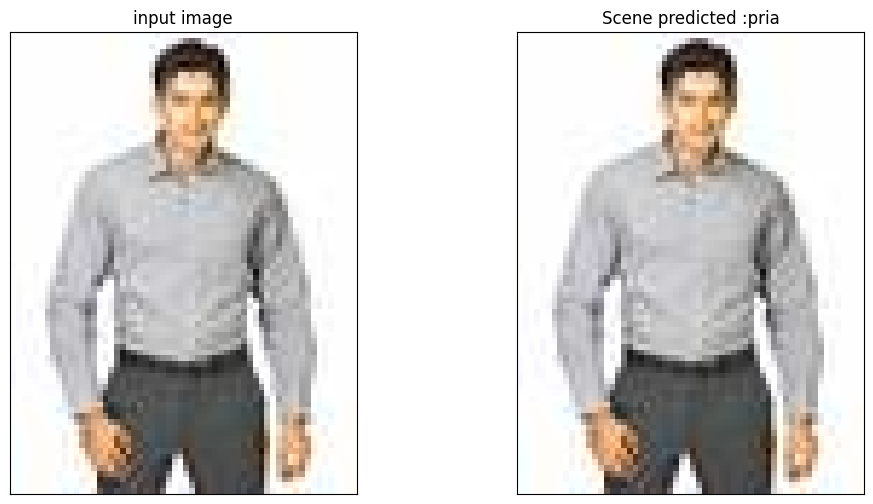

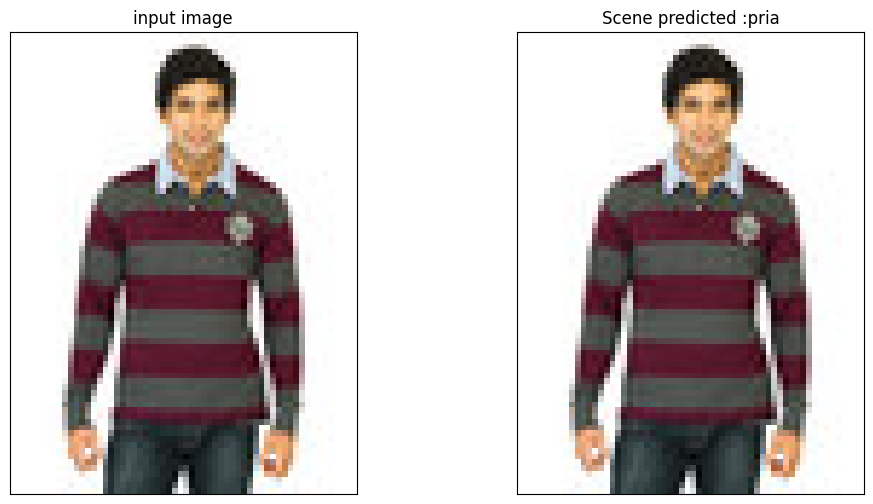

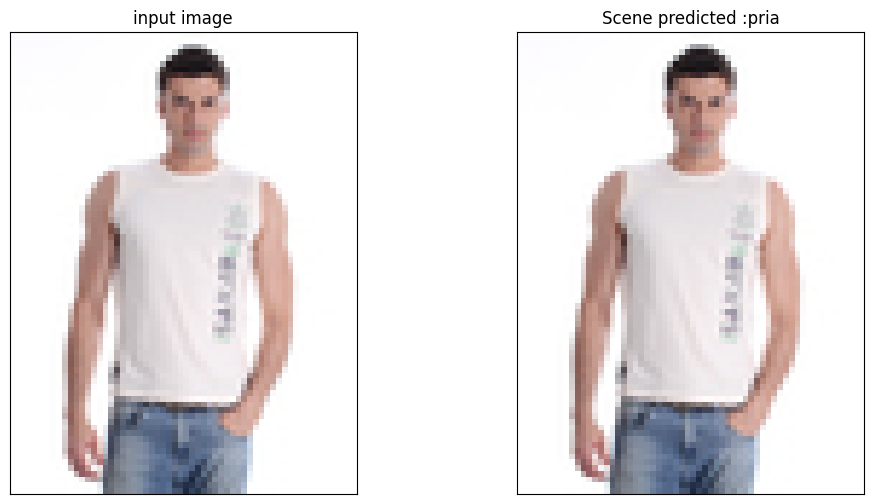

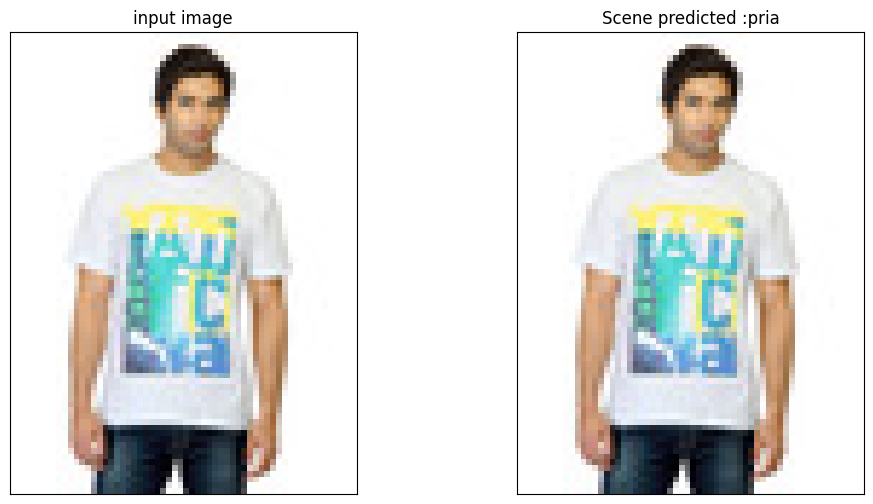

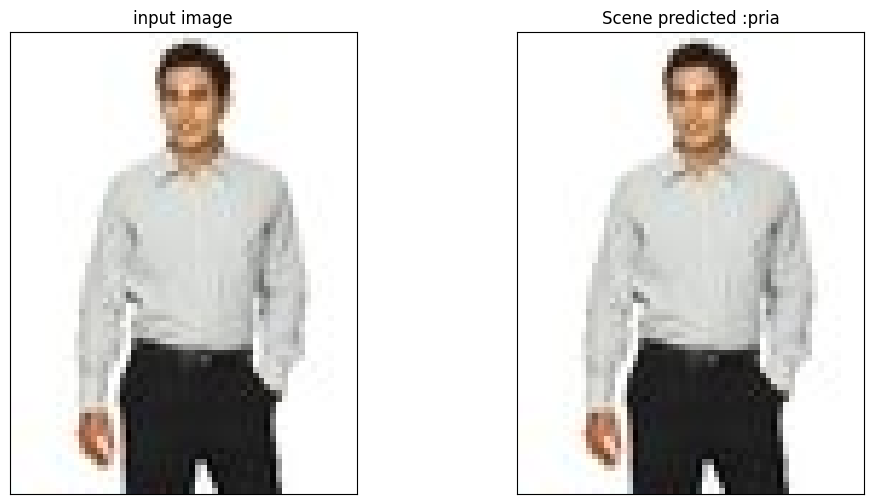

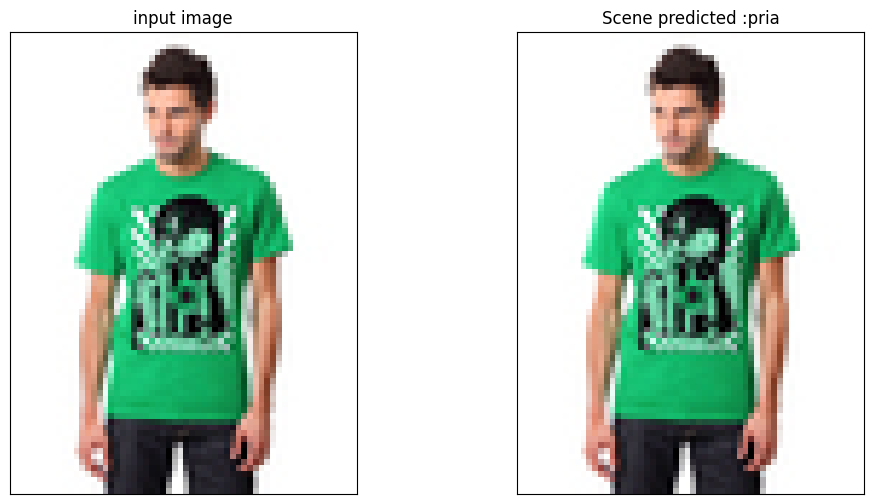

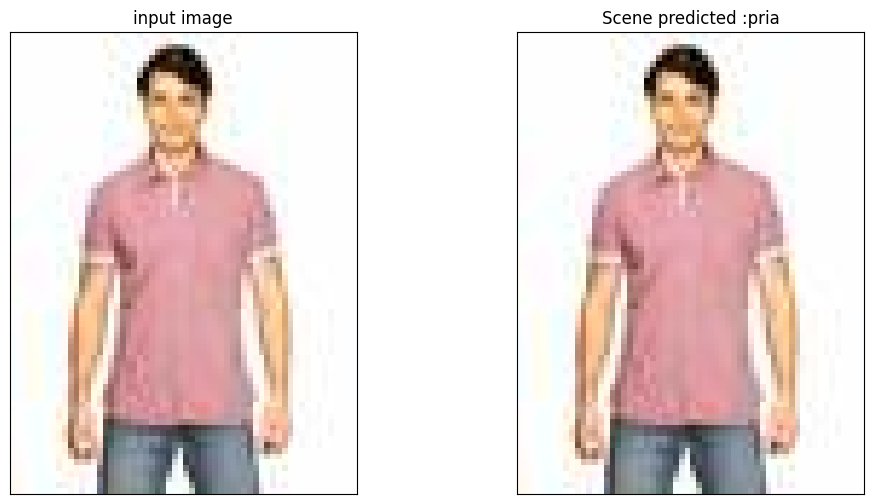

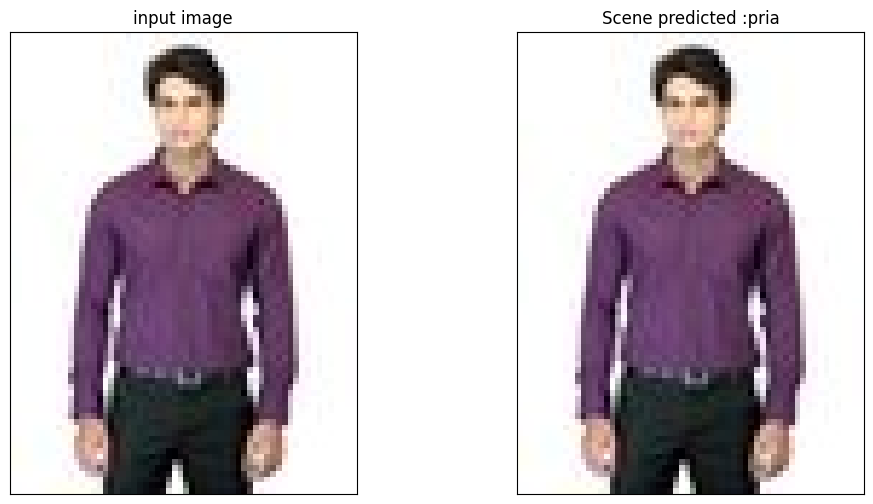

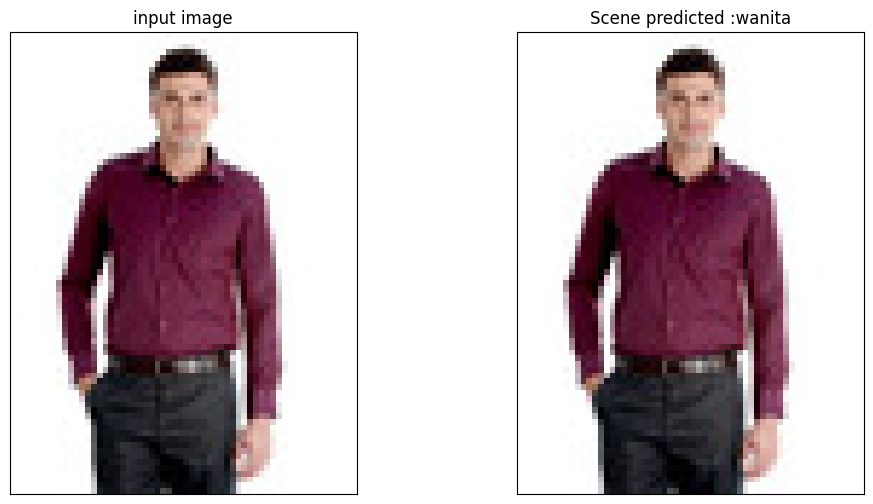

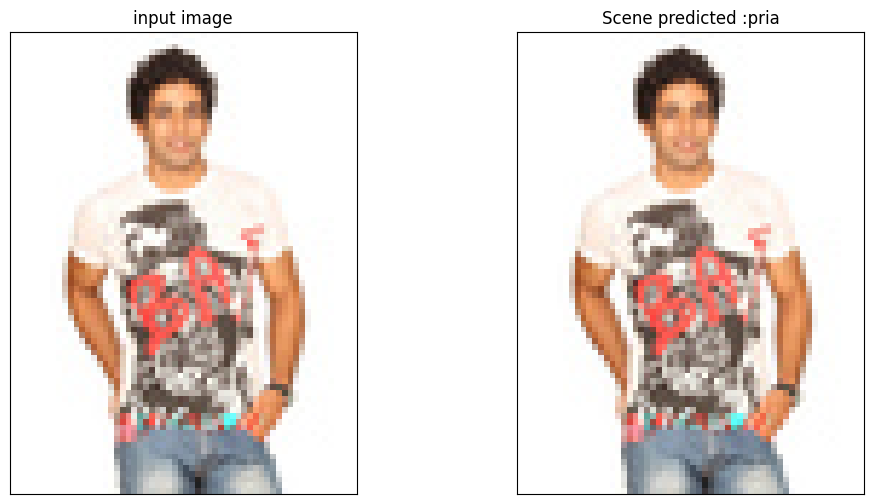

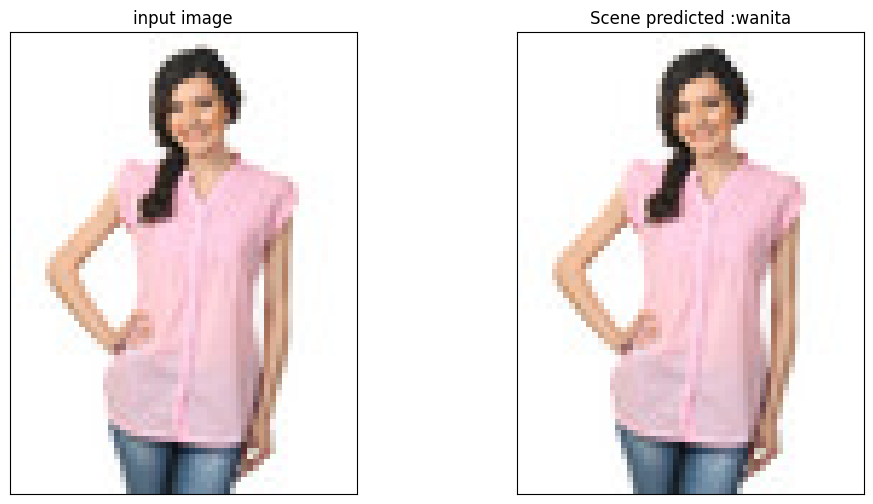

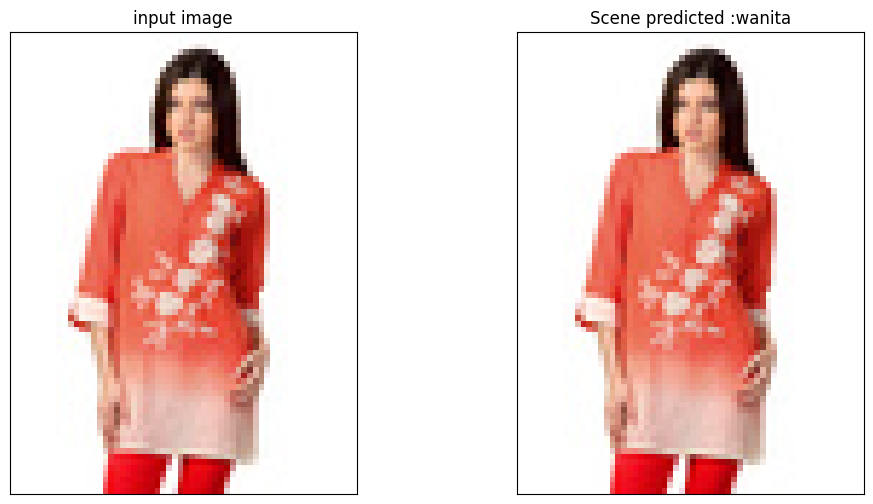

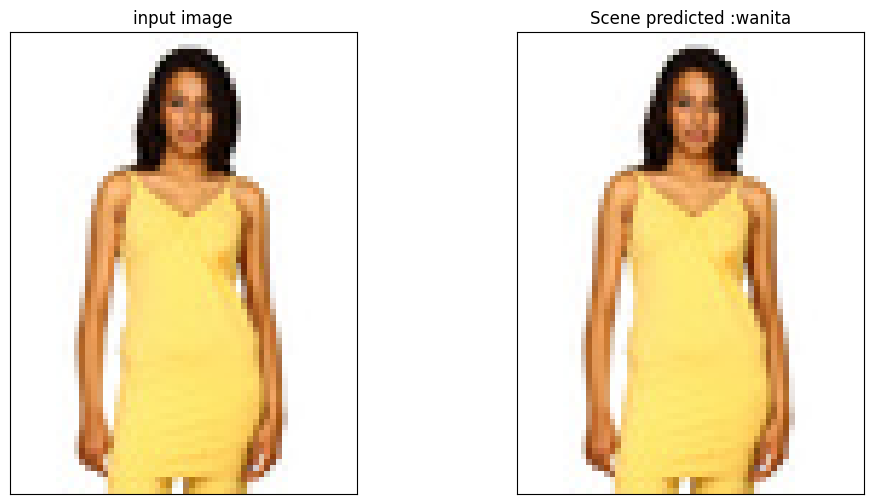

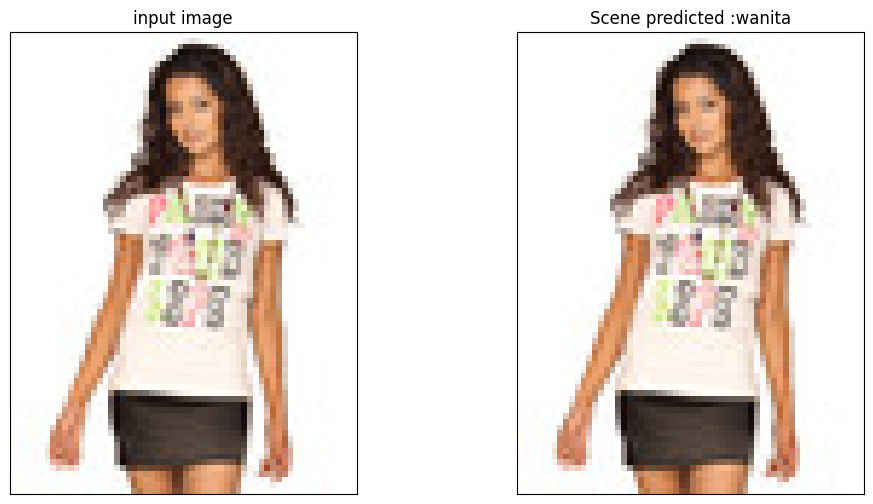

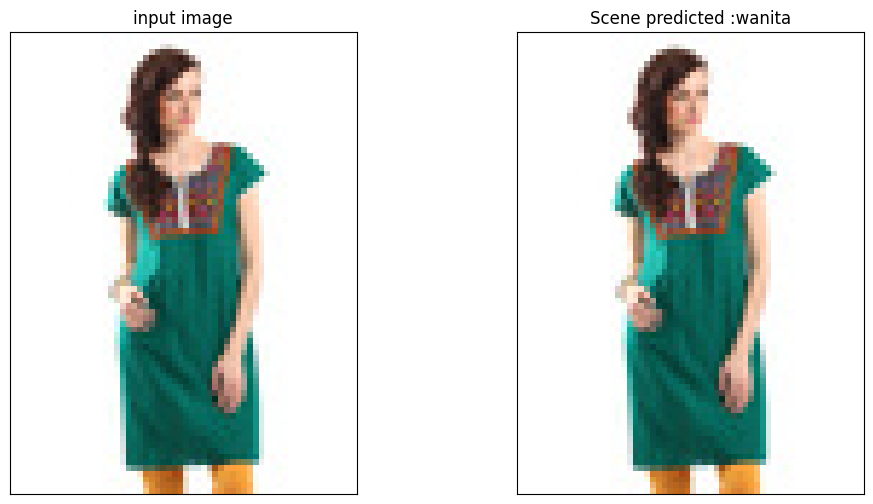

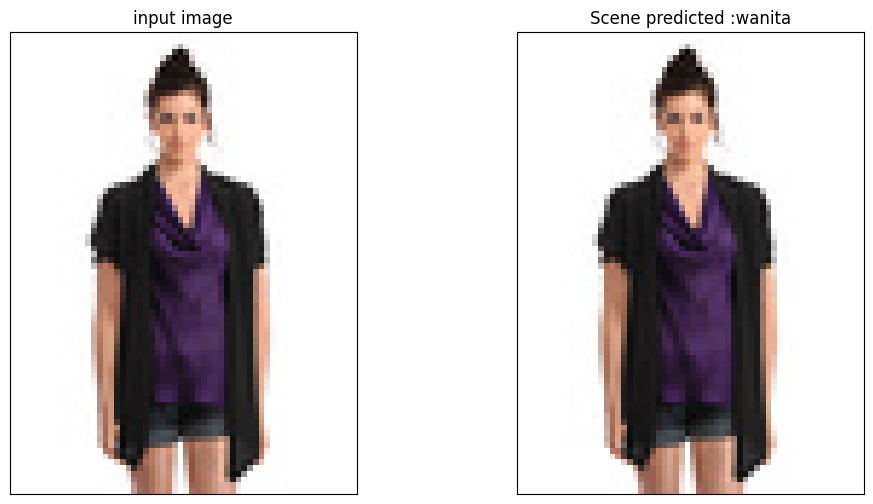

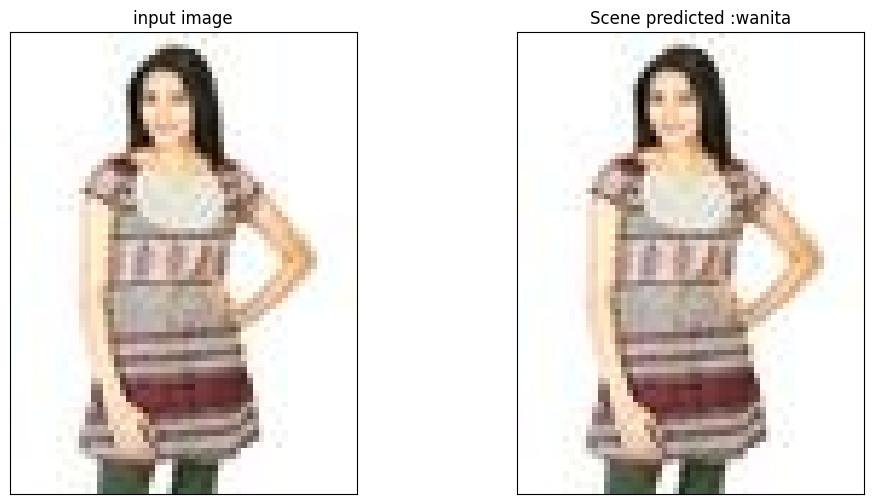

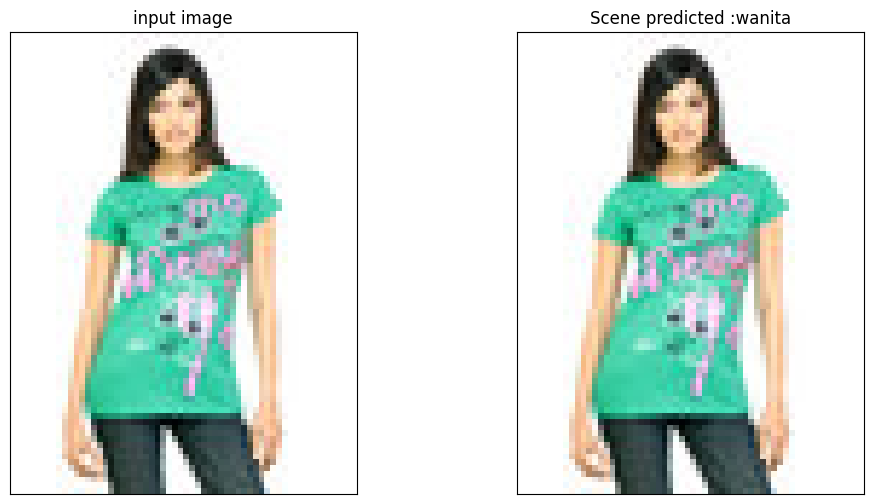

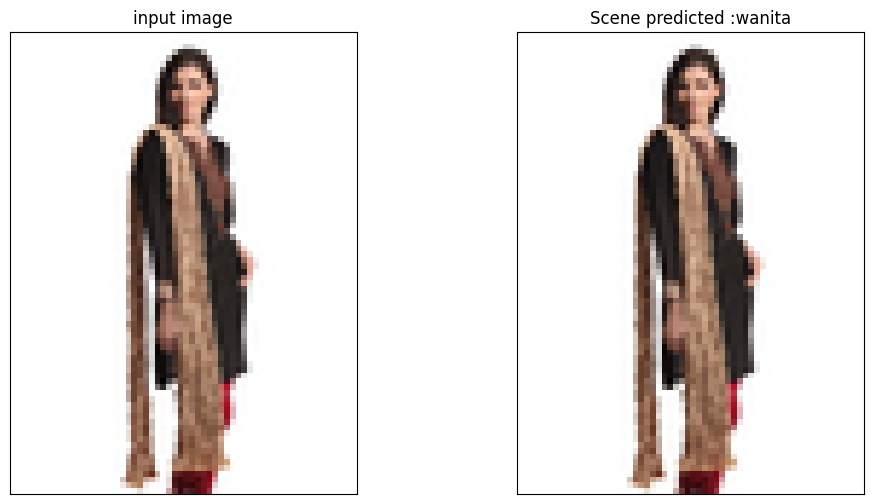

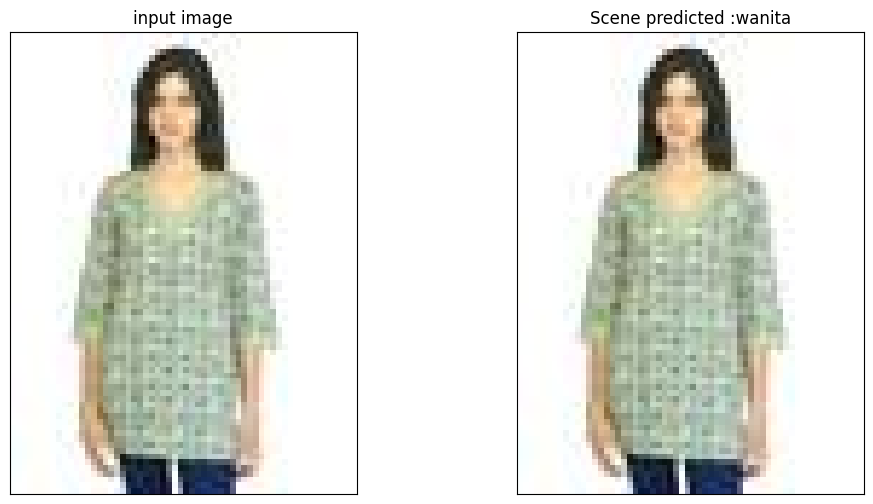

In [23]:
def scene_predict(img_path):
  image = cv2.imread(img_path)
  ip_image = Image.open(img_path)
  y = hog_data_extractor(img_path)
  z = np.matmul(a,y)
  if z > z_batas :
    gender_predicted = 'pria'
  else :
    gender_predicted = 'wanita'
  fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw=dict(xticks=[], yticks=[]))
  ax[0].imshow(ip_image)
  ax[0].set_title('input image')

  ax[1].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  ax[1].set_title('Scene predicted :'+ gender_predicted)

for item in gender :
    img_path = 'kontekstual/'+item+'_test'
    l = os.listdir(img_path)
    for i in range(10) :
      scene_predict(img_path+"/"+l[i])

## KNN

In [24]:
def samain(file) :
  if file in os.listdir('kontekstual/pria_test') :
    img_path ='kontekstual/pria_test/'+file
  else :
    img_path ='kontekstual/wanita_test/'+file
  image = cv2.imread(img_path)
  ip_image = Image.open(img_path)
  fig, ax = plt.subplots(1,1 , figsize=(12, 6),
                          subplot_kw=dict(xticks=[], yticks=[]))
  ax.imshow(ip_image)
  ax.set_title('Barang yang akan dibeli')
  Y = np.asmatrix(X_train)
  y = hog_data_extractor(img_path)
  S=np.linalg.inv(S_pl)
  distance = []
  for k in range(7000) :
    d = float((y-Y[k]) @ S @ np.transpose((y-Y[k])))
    distance.append(d)
    clear_output(wait=True)
    print(k,"/",7000)
  id = np.array(distance).argsort()[1:6]
  l = os.listdir('kontekstual/pria_train')
  l = l+os.listdir('kontekstual/wanita_train')
  ip_image = dict()
  for i in range(5) :
    nama = l[id[i]]
    if id[i]<3500 :
      img_path ='kontekstual/pria_train/'+nama
    else :
      img_path ='kontekstual/wanita_train/'+nama
    image = cv2.imread(img_path)
    ip_image[i] = Image.open(img_path)
  fig, ax = plt.subplots(1, 5, figsize=(12, 6),
                          subplot_kw=dict(xticks=[], yticks=[]))
  for j in range(5):
    ax[j].imshow(ip_image[j])
    ax[j].set_title('barang yang sama '+str(j+1))

6999 / 7000


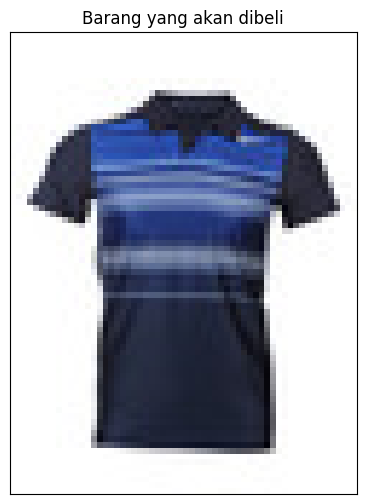

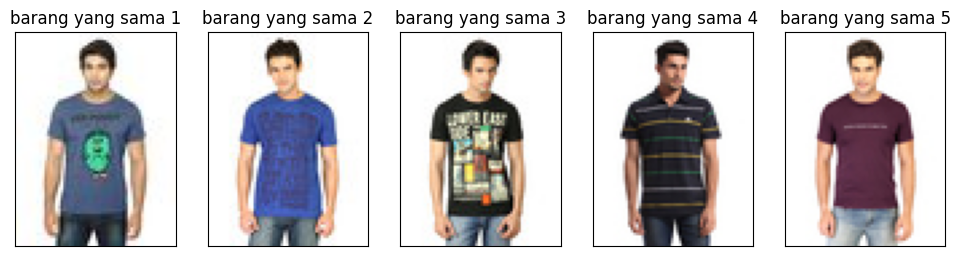

In [27]:
samain('10022.jpg')

6999 / 7000


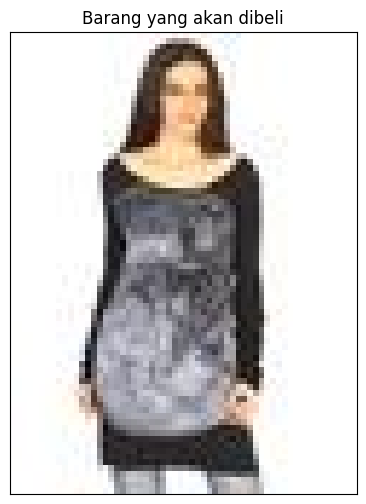

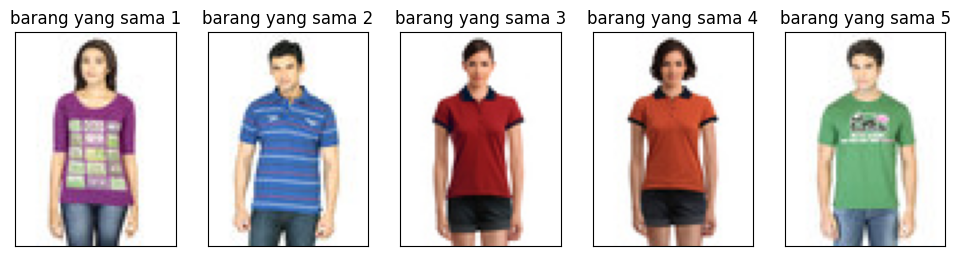

In [28]:
samain('10342.jpg')